In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
print("Tensorflow Version:",tf.__version__)

Tensorflow Version: 2.3.0



### INDEX
[1.- LOAD DATA USING IMAGE GENREATORS](#1)

[2.-Create a CNN From Scracth](#2)



<a id='1'></a>
##  1.- LOAD DATA USING IMAGE GENREATORS

In [26]:
### Initiate an instnace of ImagaDataGenerator ###
##  More in Data Augmentation: 
## https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
path = "Data_Set"                                                                             # Dataset Path
###################################### Create Data Generator ##############################################################
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,       # Split for Test/Validation
                                                                  rotation_range=15,          # Random rotation in Degrees
                                                                  height_shift_range=0.2,     # Height Shift
                                                                  brightness_range=(0.5, 1.), # Brightness
                                                                  rescale=0.9,                # Rescale 
                                                                  )   

############################################## TRAINING DATASET ##############################################################
train_dataset = image_generator.flow_from_directory(batch_size=64,                        # Batch Size
                                                 directory=path,                          # Directory
                                                 shuffle=True,                            # Shuffle images
                                                 target_size=(100, 100),                  # Resize to 100x100
                                                 color_mode="rgb",                        # Set RGB as default
                                                 subset="training",                       # Set Subset to Training
                                                 class_mode='categorical'                 # Set Data to Categoriacal
                                                 )
############################################## TESTING DATASET ##############################################################
validation_dataset = image_generator.flow_from_directory(batch_size=64,                   # Batch Size
                                                 directory=path,                          # Directory
                                                 shuffle=True,                            # Shuffle images
                                                 target_size=(100, 100),                  # Resize to 100x100
                                                 subset="validation",                     # Set Subset to Validation
                                                 color_mode="rgb",                         # Set RGB as default
                                                 class_mode='categorical')                # Set Data to Categoriacal

Found 1039 images belonging to 4 classes.
Found 258 images belonging to 4 classes.


### 1.1.- Calculate Steps that have to be taken every epoch

In [27]:
val_steps = validation_dataset.n // validation_dataset.batch_size  # Steps in an epoch Validation Data
train_steps = train_dataset.n // train_dataset.batch_size          # Steps in an epoch for Traninning Data
###################################### INFROM THE USER ABOUT THE STEPS #####################################################
print(f"Train steps per epoch: {train_steps}")                     # Steps in an epoch for Traninning Data
print(f"Validation steps per epoch: {val_steps}")                  # Steps in an epoch Validation Data

Train steps per epoch: 16
Validation steps per epoch: 4


### 1.2.- Get tha labels for each class

In [28]:
#### All the labels are stored in Lables.txt file ######
path = "Data_set/Labels.txt"              # Path for Label txt file
with open(path,"r") as handler:           # Open txt file
    labels = handler.read().splitlines()  # Create a list based on every new line
print(labels)                             # Show the labels


['Back,', 'Front,', 'Left,', 'Right']


<br>
<br>

<a id='2'></a>
#  2.-Create a CNN From Scracth

In [40]:
def get_new_model(rate=0.5):
    """
    Convolutional Neural Network with Droput
    """
    ############################### NEURAL NETWORK ARCHITECTURE ############################################
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=((100, 100, 3))))
    model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same",name="conv_1"))
    model.add(tf.keras.layers.Dropout(rate))
    model.add(tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),activation="relu",padding="same",name="conv_2"))
    model.add(tf.keras.layers.Dropout(rate))
    model.add(tf.keras.layers.Conv2D(filters=8,kernel_size=(3,3),activation="relu",padding="same",name="conv_3"))
    model.add(tf.keras.layers.Dropout(rate))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(8,8),name="pool_1"))
    
    model.add(tf.keras.layers.Flatten(name="flatten"))
    model.add(tf.keras.layers.Dense(units=32,activation="relu",name="dense_1"))
    model.add(tf.keras.layers.Dense(units=4,activation="softmax",name="dense_2"))
    
    ########################### Compilation of CNN ########################################################
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model 

def get_test_accuracy(model,data,steps,**kwargs):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate_generator(data,steps,**kwargs)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))
    

def get_checkpoint_best_only():
    """
    - saves only the weights that generate the highest validation (testing) accuracy
    """
    path = r'C:\Users\Eduardo\Documents\CARRERA\8vo_semestre\BIO_4\Lab\3_Silla_de_ruedas\Python\Weights\weights'# path to save model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=path, save_best_only=True,save_weights_only=True,verbose=2)
    return checkpoint

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 5 epochs.
    EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    return tf.keras.callbacks.EarlyStopping(monitor='accuracy',min_delta=0.01,patience=5,mode="max")
    
    
def plot_learning(history):
    """PLOT LEARNING CUVRVES """
    figrue, ax = plt.subplots(1,2,figsize=(15,6))                            # Create Figure
    ax[0].set_title("Loss Vs Epochs")                                        # Set Title
    ax[0].plot(history.history['loss'],label=" Trainining Loss")             # Plot Training Loss
    ax[0].plot(history.history['val_loss'],label="Validation Loss")          # Plot Validation Loss
    ax[0].legend()                                                           # Print Labels in plot

    ax[1].set_title("Accuracy Vs Epochs")                                    # Set Title
    ax[1].plot(history.history['accuracy'],label=" Trainining Accurcacy")    # Plot Training Accuracy
    ax[1].plot(history.history['val_accuracy'],label="Validation Accurcacy") # Plot Validation Accuracy
    ax[1].legend()                                                           # Print Labels in plot
    
    plt.show()                                                               # Show plot
    ## THERE IS NOTHING TO RETURN  ##

In [41]:
model = get_new_model()                                # Initiate Model
get_test_accuracy(model,validation_dataset,val_steps)  # Test intial Accruacy (without Trainning)
model.summary()                                        # Get Model Architecture

accuracy: 0.227
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 100, 100, 16)      2320      
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 100, 100, 8)       1160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 100, 8)       0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 12

### 2.1 Train Model

Epoch 1/40
16/16 [==============================] - ETA: 0s - loss: 78.3170 - accuracy: 0.2636
Epoch 00001: val_loss improved from inf to 3.59873, saving model to C:\Users\Eduardo\Documents\CARRERA\8vo_semestre\BIO_4\Lab\3_Silla_de_ruedas\Python\Weights\weights
16/16 [==============================] - 18s 1s/step - loss: 78.3170 - accuracy: 0.2636 - val_loss: 3.5987 - val_accuracy: 0.2773
Epoch 2/40
16/16 [==============================] - ETA: 0s - loss: 5.5446 - accuracy: 0.2995
Epoch 00002: val_loss improved from 3.59873 to 2.05446, saving model to C:\Users\Eduardo\Documents\CARRERA\8vo_semestre\BIO_4\Lab\3_Silla_de_ruedas\Python\Weights\weights
16/16 [==============================] - 17s 1s/step - loss: 5.5446 - accuracy: 0.2995 - val_loss: 2.0545 - val_accuracy: 0.2852
Epoch 3/40
16/16 [==============================] - ETA: 0s - loss: 2.9753 - accuracy: 0.3538
Epoch 00003: val_loss improved from 2.05446 to 1.69252, saving model to C:\Users\Eduardo\Documents\CARRERA\8vo_semestre\

16/16 [==============================] - ETA: 0s - loss: 1.0162 - accuracy: 0.6215
Epoch 00024: val_loss did not improve from 1.32388
16/16 [==============================] - 17s 1s/step - loss: 1.0162 - accuracy: 0.6215 - val_loss: 1.3785 - val_accuracy: 0.3594
Epoch 25/40
16/16 [==============================] - ETA: 0s - loss: 0.9384 - accuracy: 0.6308
Epoch 00025: val_loss did not improve from 1.32388
16/16 [==============================] - 16s 1s/step - loss: 0.9384 - accuracy: 0.6308 - val_loss: 1.3455 - val_accuracy: 0.4531
Epoch 26/40
16/16 [==============================] - ETA: 0s - loss: 0.9107 - accuracy: 0.6338
Epoch 00026: val_loss did not improve from 1.32388
16/16 [==============================] - 16s 1s/step - loss: 0.9107 - accuracy: 0.6338 - val_loss: 1.3603 - val_accuracy: 0.4375
Epoch 27/40
16/16 [==============================] - ETA: 0s - loss: 0.9104 - accuracy: 0.6523
Epoch 00027: val_loss did not improve from 1.32388
16/16 [==============================] - 

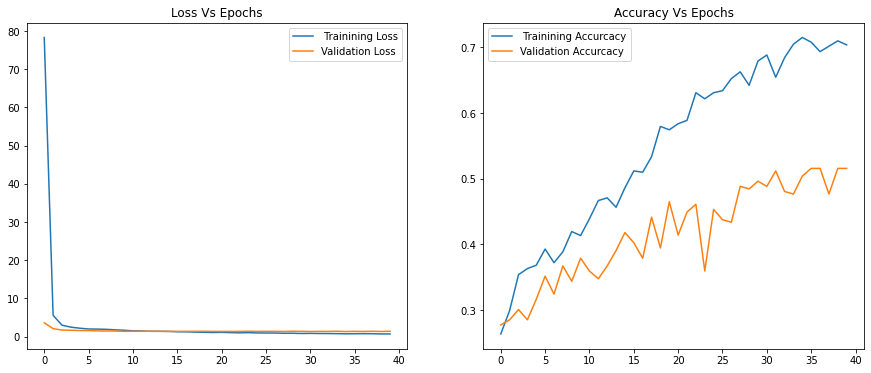

In [42]:
checkpoint_best_only = get_checkpoint_best_only()  # Get best only save
early_stopping = get_early_stopping()              # Get Early stopping
callbacks = [checkpoint_best_only, early_stopping] # Put callbacks in a list

### Train model using the callbacks ##
history = model.fit(train_dataset,                            # Data generator for Training
                    steps_per_epoch =train_steps,             # Steps in an epoch of Training  Data
                    validation_data =  validation_dataset,    # Data Generator for Validation
                    validation_steps=val_steps,               # Steps in a epoch of Validation Data
                    epochs=40,callbacks=callbacks              # Callbacks
                    )

plot_learning(history)                                        # Plot learning curves at the end 

In [43]:
img = cv2.imread('Data_Set/Back/Back112.jpg')    # Get image
img = cv2.imread('Data_Set/Right/Right68.jpg')   # Get Right 
img = cv2.imread('Data_Set/Left/Left59.jpg')     # Left

img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB )         
prediction = model.predict(img[np.newaxis,...])  # Make Prediction
y_predict = np.argmax(prediction)                # Get Maximum Probability
print(labels[y_predict])

Left,


### 2.2 Test Model in Video 

In [44]:
## This is just an example to ilustrate how to use Haar Cascades in order to detect objects (LIVE) ##
face = cv2.CascadeClassifier('Haarcascade/haarcascade_frontalface_default.xml') # Face Haar Cascade loading
eye = cv2.CascadeClassifier('Haarcascade/haarcascade_eye.xml')                  # Eye  Haar Cascade Loading
vid = cv2.VideoCapture(0)                                                       # Define a video capture object 
status = True                                                                   # Initalize status
width = 100                                                                     # Width
height = 100                                                                    # Height
dimensions=(width,height)                                                       # Dimenssions
font = cv2.FONT_HERSHEY_SIMPLEX
while(status):                                             # Iterate while status is true 
    status, frame = vid.read()                             # Capture the video frame by frame 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)         # Convert to gray scale
    face_info = face.detectMultiScale(gray, 1.3, 5)        # Get face infromation
    for (x,y,w,h) in face_info:                            # Iterate over this information
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,0),1) # Draw rectangle
        cropped_face_color = frame[y:y+h, x:x+w]           # Crop face (color) 
    if face_info  != ():                                   # If face was capture
        res = cv2.resize(cropped_face_color,dimensions, interpolation=cv2.INTER_AREA) # Resize
        res =  cv2.cvtColor(res, cv2.COLOR_BGR2RGB )         # Convert to RGB
        prediction = model.predict(res[np.newaxis,...])        # Make Prediction
        y_predict = np.argmax(prediction)                      # Get Maximum Probability
        y_prediction_text = labels[y_predict]                  # Get Text of prediction
        cv2.putText(frame,y_prediction_text,(20,20), font, 1,(255,255,0),2)
    
    
    cv2.imshow('frame',  frame)                            # Display the resulting frame 
    wait_key = cv2.waitKey(1) & 0xFF                       # Store Waitkey object
    if wait_key  == ord('q'):                              # If q is pressed
        break                                              # Break while loop
  
    

vid.release()              # After the loop release the cap object 
cv2.destroyAllWindows()    # Destroy all the windows 

C:\Users\Eduardo\Documents\CARRERA\Udemy\Deep_Learning_Prerequisites_The_Numpy_Stack_in_Python\machine_learning_env\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


<br>
<br>

<a id='2'></a>
#  2.- Use Transfer Learning 

![image](https://miro.medium.com/max/850/1*_Lg1i7wv1pLpzp2F4MLrvw.png)

In [49]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [69]:
image_size = [100,100,3]               # Add image size we wish to train Data with
### Intiate VGG16  ###
vgg =  VGG16(input_shape=image_size,   # Input Shape
             weights='imagenet',       # Dataset used to train weights
             include_top=False         # Do not include Top   
            )
##### MAKE ALL LAYERS UNTRAINABLE ###
maximum = 7
i=0
for layer in vgg.layers:              # Iterate over layers 
    if i < maximum:                   # if layer index is less than the one we specified
        layer.trainable = False       # Make layer untrianable
    i+=1
    
vgg.layers                             # Print VGG Layers                                                           

In [75]:
vgg.layers[6].trainable

False

In [78]:
x =  Flatten()(vgg.output)
prediction = Dense(4,activation="softmax")(x)
model2 = tf.keras.models.Model(inputs=vgg.input,outputs=prediction)
model2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()
#history = model2.fit(train_dataset,steps_per_epoch=train_steps,epochs=4)

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

Epoch 1/10
16/16 [==============================] - 142s 9s/step - loss: 1.3862 - accuracy: 0.2626 - val_loss: 1.3860 - val_accuracy: 0.2695
Epoch 2/10
16/16 [==============================] - 143s 9s/step - loss: 1.3861 - accuracy: 0.2677 - val_loss: 1.3860 - val_accuracy: 0.2695
Epoch 3/10
16/16 [==============================] - 143s 9s/step - loss: 1.3859 - accuracy: 0.2749 - val_loss: 1.3860 - val_accuracy: 0.2656
Epoch 4/10
16/16 [==============================] - 143s 9s/step - loss: 1.3858 - accuracy: 0.2687 - val_loss: 1.3858 - val_accuracy: 0.2695
Epoch 5/10
16/16 [==============================] - 188s 12s/step - loss: 1.3858 - accuracy: 0.2656 - val_loss: 1.3858 - val_accuracy: 0.2656
Epoch 6/10
16/16 [==============================] - 312s 19s/step - loss: 1.3859 - accuracy: 0.2626 - val_loss: 1.3858 - val_accuracy: 0.2656
Epoch 7/10
16/16 [==============================] - 296s 18s/step - loss: 1.3858 - accuracy: 0.2646 - val_loss: 1.3858 - val_accuracy: 0.2656
Epoch 8/10

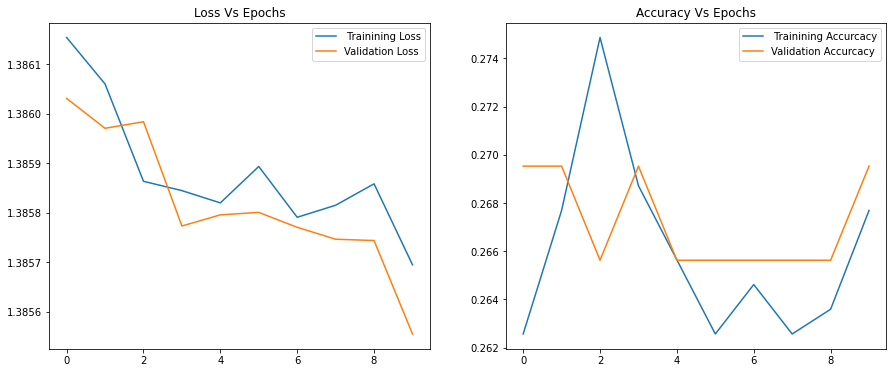

In [80]:
history = model2.fit(train_dataset,                            # Data generator for Training
                    steps_per_epoch =train_steps,             # Steps in an epoch of Training  Data
                    validation_data =  validation_dataset,    # Data Generator for Validation
                    validation_steps=val_steps,               # Steps in a epoch of Validation Data
                    epochs=10)

plot_learning(history)          

In [81]:
## This is just an example to ilustrate how to use Haar Cascades in order to detect objects (LIVE) ##
face = cv2.CascadeClassifier('Haarcascade/haarcascade_frontalface_default.xml') # Face Haar Cascade loading
eye = cv2.CascadeClassifier('Haarcascade/haarcascade_eye.xml')                  # Eye  Haar Cascade Loading
vid = cv2.VideoCapture(0)                                                       # Define a video capture object 
status = True                                                                   # Initalize status
width = 100                                                                     # Width
height = 100                                                                    # Height
dimensions=(width,height)                                                       # Dimenssions
font = cv2.FONT_HERSHEY_SIMPLEX
while(status):                                             # Iterate while status is true 
    status, frame = vid.read()                             # Capture the video frame by frame 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)         # Convert to gray scale
    face_info = face.detectMultiScale(gray, 1.3, 5)        # Get face infromation
    for (x,y,w,h) in face_info:                            # Iterate over this information
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,0),1) # Draw rectangle
        cropped_face_color = frame[y:y+h, x:x+w]           # Crop face (color) 
    if face_info  != ():                                   # If face was capture
        res = cv2.resize(cropped_face_color,dimensions, interpolation=cv2.INTER_AREA) # Resize
        prediction = model2.predict(res[np.newaxis,...])        # Make Prediction
        y_predict = np.argmax(prediction)                      # Get Maximum Probability
        y_prediction_text = labels[y_predict]                  # Get Text of prediction
        cv2.putText(frame,y_prediction_text,(20,20), font, 1,(255,255,0),2)
    
    
    cv2.imshow('frame',  frame)                            # Display the resulting frame 
    wait_key = cv2.waitKey(1) & 0xFF                       # Store Waitkey object
    if wait_key  == ord('q'):                              # If q is pressed
        break                                              # Break while loop
  
    

vid.release()              # After the loop release the cap object 
cv2.destroyAllWindows()    # Destroy all the windows 

C:\Users\Eduardo\Documents\CARRERA\Udemy\Deep_Learning_Prerequisites_The_Numpy_Stack_in_Python\machine_learning_env\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
